In [1]:
"""
Swap Error Analysis for Index-Cued Networks
Step 1: Load model, generate trials, identify swaps
"""

import os
os.chdir('/homes/pr450/repos/research_projects/sampling_ddpm')

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import os
import torch
import numpy as np
from tqdm import tqdm

# Your existing imports
from ddpm.model.main.multiepoch import MultiPreparatoryHVAEReverseProcess
from ddpm.utils.loading import generate_model_and_task_from_args_path_multiepoch
from purias_utils.multiitem_working_memory.util.circle_utils import rectify_angles, polar2cart

# Configuration
BASE_DIR = '/homes/pr450/repos/research_projects/sampling_ddpm'
RUN_NAME = 'run_c3_index_cued_diffusion_0.1_swap_0'  # The 0.1 swap model
BASE_DIR_NAME = 'hvae_with_dendritic_20250410'
DEVICE = 'cuda'

# Analysis parameters
NUM_TRIALS = 100  # How many different stimulus configurations
NUM_SAMPLES_PER_TRIAL = 64  # How many "neural" samples per trial
GRID_POINTS = 24  # Color space discretization

print(f"Loading model: {RUN_NAME}")

# Load the model
args_path = f'{BASE_DIR}/results_link_sampler/{BASE_DIR_NAME}/{RUN_NAME}/args.yaml'
state_path = f'{BASE_DIR}/results_link_sampler/{BASE_DIR_NAME}/{RUN_NAME}/state.mdl'

_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(args_path, DEVICE)
ddpm_model.load_state_dict(torch.load(state_path, weights_only=True))
ddpm_model.eval()

# Turn off gradients
for parameter in ddpm_model.parameters():
    parameter.requires_grad = False

print("Model loaded successfully!")

# Generate stimulus space
minimum_margin = torch.pi / task.task_variable_gen.min_sep
unique_feature_values = torch.linspace(0, 2 * torch.pi, GRID_POINTS + 1)[:-1]
unique_feature_values = rectify_angles(unique_feature_values)

print(f"Stimulus space: {GRID_POINTS} colors, minimum separation: {minimum_margin:.3f} rad")


def generate_trials(num_trials, num_samples, use_fixed_probe_pair=None):
    """
    Generate trials and identify swaps.
    
    Args:
        num_trials: Number of different stimulus configurations
        num_samples: Number of samples per configuration
        use_fixed_probe_pair: If provided, (probe1_idx, probe2_idx) to test specific pair
    
    Returns:
        dict with trial_data, swap_mask, and statistics
    """
    
    if use_fixed_probe_pair is not None:
        # Use specific probe pair
        probe1_idx, probe2_idx = use_fixed_probe_pair
        probe1_val = unique_feature_values[probe1_idx]
        probe2_val = unique_feature_values[probe2_idx]
        
        # For index-cued task, we need valid combinations
        probe_features = torch.stack([probe1_val.repeat(2), probe2_val.repeat(2)]).T
        report_features = probe_features.clone()
        selected_feature_idx = torch.tensor([0, 1])  # Both cue conditions
        
        batch_size = 2
    else:
        # Sample random valid probe pairs
        valid_pairs = []
        for _ in range(num_trials):
            # Sample two colors that are far enough apart
            while True:
                idx1, idx2 = torch.randint(0, GRID_POINTS, (2,))
                val1, val2 = unique_feature_values[idx1], unique_feature_values[idx2]
                if rectify_angles(val1 - val2).abs() > minimum_margin:
                    valid_pairs.append((val1, val2, torch.randint(0, 2, (1,)).item()))
                    break
        
        probe_features = torch.tensor([[p[0], p[1]] for p in valid_pairs])
        report_features = probe_features.clone()
        selected_feature_idx = torch.tensor([p[2] for p in valid_pairs])
        batch_size = num_trials
    
    # Create stimulus dict
    override_stimulus_features_dict = {
        'probe_features': probe_features,
        'report_features': report_features,
        'cued_item_idx': selected_feature_idx
    }
    
    # Add cartesian coordinates
    for k in ['probe_features', 'report_features']:
        cart_features = torch.stack(polar2cart(1.0, override_stimulus_features_dict[k]), -1)
        override_stimulus_features_dict[f'{k}_cart'] = cart_features
    
    # Generate task variables
    task_variable_dict = task.task_variable_gen.generate_variable_dict(
        batch_size=batch_size,
        override_stimulus_features_dict=override_stimulus_features_dict
    )
    
    # Generate trial
    trial_information = task.generate_trial_information(
        batch_size=batch_size,
        num_samples=num_samples,
        override_task_variable_information=task_variable_dict
    )
    
    # Run the model
    print("Running model to generate samples...")
    with torch.no_grad():
        novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
            prep_network_inputs=trial_information.prep_network_inputs,
            diffusion_network_inputs=trial_information.diffusion_network_inputs,
            prep_epoch_durations=trial_information.prep_epoch_durations,
            diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
            samples_shape=[batch_size, num_samples],
            noise_scaler=1.0,
        )
    
    # Identify swaps
    print("Identifying swap errors...")
    selected_report_value = torch.arctan2(
        novel_samples_dict['samples'][..., 1],
        novel_samples_dict['samples'][..., 0]
    )
    
    # Calculate errors
    actual_errors = rectify_angles(
        selected_report_value - 
        report_features[range(batch_size), selected_feature_idx, None]
    )
    swapped_errors = rectify_angles(
        selected_report_value - 
        report_features[range(batch_size), 1 - selected_feature_idx, None]
    )
    
    # Swap criterion: closer to distractor than target
    swap_mask = (actual_errors.abs() > swapped_errors.abs())
    
    swap_rate = swap_mask.float().mean().item()
    print(f"Swap rate: {swap_rate:.3%}")
    
    return {
        'novel_samples_prep_dicts': novel_samples_prep_dicts,
        'novel_samples_dict': novel_samples_dict,
        'trial_information': trial_information,
        'swap_mask': swap_mask,
        'actual_errors': actual_errors,
        'swapped_errors': swapped_errors,
        'swap_rate': swap_rate,
        'probe_features': probe_features,
        'report_features': report_features,
        'selected_feature_idx': selected_feature_idx,
    }


test_data = generate_trials(
    num_trials=1,
    num_samples=NUM_SAMPLES_PER_TRIAL,
    use_fixed_probe_pair=(0, 12)  # Opposite colors
)

full_data = generate_trials(
    num_trials=NUM_TRIALS,
    num_samples=NUM_SAMPLES_PER_TRIAL,
    use_fixed_probe_pair=None
)

Loading model: run_c3_index_cued_diffusion_0.1_swap_0
Model loaded successfully!
Stimulus space: 24 colors, minimum separation: 0.766 rad
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
Running model to generate samples...


/scratch/anaconda3/envs/torch_v2/lib/python3.12/site-packages/torch/_tensor.py:1488: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1736187088862/work/c10/core/TensorImpl.h:1928.)
  return super().rename(names)


Identifying swap errors...
Swap rate: 7.812%
USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
Running model to generate samples...
Identifying swap errors...
Swap rate: 9.625%


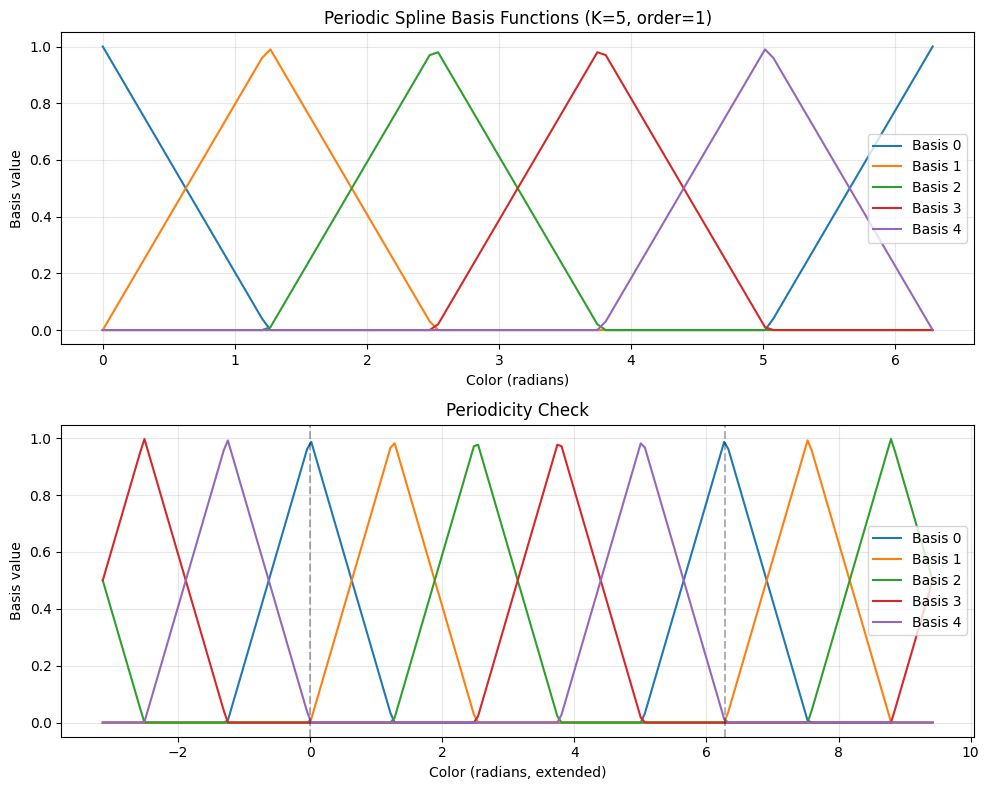

Sample colors: [0.        1.5707964 3.1415927 4.712389 ]
Basis representation shape: torch.Size([4, 5])
Basis values sum to ~1: [1. 1. 1. 1.]


In [2]:
"""
Periodic spline basis functions for color representation
"""

import torch
import numpy as np
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt


def create_periodic_spline_basis(num_knots, order):
    """
    Create periodic B-spline basis functions for circular color space.
    For order=1, these are linear "tent" functions.
    
    Args:
        num_knots: Number of knots (K in the paper)
        order: Spline order (1 = linear tents, 2 = quadratic, etc.)
    
    Returns:
        Function that transforms colors [0, 2π] to K-dimensional representation
    """
    # Knot positions uniformly distributed on [0, 2π]
    knots = torch.linspace(0, 2*np.pi, num_knots + 1)[:-1]
    spacing = 2*np.pi / num_knots
    
    def transform_color(colors):
        """
        Transform color(s) to spline basis representation.
        
        Args:
            colors: torch.Tensor of shape (...,) with values in [0, 2π]
        
        Returns:
            torch.Tensor of shape (..., num_knots) with spline basis values
        """
        original_shape = colors.shape
        colors_flat = colors.flatten().unsqueeze(-1)  # (N, 1)
        knots_expanded = knots.to(colors.device).unsqueeze(0)  # (1, K)

        if order == 1:
            # Linear B-splines (tent functions)
            # For each basis function centered at knot i:
            # - Full support from knot[i-1] to knot[i+1]
            # - Linear ramp up from i-1 to i, linear ramp down from i to i+1
            
            basis_values = torch.zeros(colors_flat.shape[0], num_knots, device=colors.device)
            
            for i in range(num_knots):
                # Angular distance to this knot (handling periodicity)
                diff = colors_flat - knots_expanded[:, i:i+1]
                # Wrap to [-π, π]
                diff = torch.atan2(torch.sin(diff), torch.cos(diff))
                
                # Linear tent function: 1 at center, 0 at ±spacing
                tent = 1.0 - torch.abs(diff) / spacing
                tent = torch.clamp(tent, 0.0, 1.0)
                
                basis_values[:, i] = tent.squeeze()
            
            # Normalize so they sum to 1
            basis_sum = basis_values.sum(dim=-1, keepdim=True)
            basis_values = basis_values / (basis_sum + 1e-8)
            
        elif order == 2:
            # Quadratic B-splines (order=2)
            # For each basis function, support is over 3 knots: [i-1, i, i+1]
            basis_values = torch.zeros(colors_flat.shape[0], num_knots, device=colors.device)
            for i in range(num_knots):
                # Center knot
                k0 = knots[i]
                # Previous and next knots (with periodic wrap)
                k_minus = knots[(i - 1) % num_knots]
                k_plus = knots[(i + 1) % num_knots]

                # Compute distances, wrapped to [-π, π]
                d_minus = torch.atan2(torch.sin(colors_flat - k_minus), torch.cos(colors_flat - k_minus))
                d0 = torch.atan2(torch.sin(colors_flat - k0), torch.cos(colors_flat - k0))
                d_plus = torch.atan2(torch.sin(colors_flat - k_plus), torch.cos(colors_flat - k_plus))

                # Quadratic tent: piecewise
                # Support is from k_minus to k_plus (width = 2*spacing)
                # Peak at k0, value 1
                # Value is 0 at k_minus and k_plus

                # Left side: between k_minus and k0
                left_mask = (d_minus >= 0) & (d0 <= 0)
                left_val = ((d_minus[left_mask] / spacing) ** 2)

                # Right side: between k0 and k_plus
                right_mask = (d0 >= 0) & (d_plus <= 0)
                right_val = ((-d_plus[right_mask] / spacing) ** 2)

                # Center: at k0
                center_mask = (d0 == 0)
                center_val = torch.ones_like(d0[center_mask])

                # Assign values
                basis_values[left_mask, i] = left_val
                basis_values[right_mask, i] = right_val
                basis_values[center_mask, i] = center_val

            # Normalize so they sum to 1
            basis_sum = basis_values.sum(dim=-1, keepdim=True)
            basis_values = basis_values / (basis_sum + 1e-8)
        
        # Reshape back
        basis_values = basis_values.reshape(*original_shape, num_knots)
        return basis_values
    
    return transform_color


# Create the spline transform
num_knots = 5
order = 1
spline_transform = create_periodic_spline_basis(num_knots=num_knots, order=order)


# Test and visualize
test_colors = torch.linspace(0, 2*np.pi, 100)
test_basis = spline_transform(test_colors)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot basis functions
ax = axes[0]
for i in range(num_knots):
    ax.plot(test_colors.numpy(), test_basis[:, i].numpy(), label=f'Basis {i}')
ax.set_xlabel('Color (radians)')
ax.set_ylabel('Basis value')
ax.set_title(f'Periodic Spline Basis Functions (K={num_knots}, order=1)')
ax.legend()
ax.grid(True, alpha=0.3)

# Check periodicity
ax = axes[1]
colors_extended = torch.linspace(-np.pi, 3*np.pi, 200)
basis_extended = spline_transform(torch.remainder(colors_extended, 2*np.pi))
for i in range(num_knots):
    ax.plot(colors_extended.numpy(), basis_extended[:, i].numpy(), label=f'Basis {i}')
ax.axvline(0, color='k', linestyle='--', alpha=0.3)
ax.axvline(2*np.pi, color='k', linestyle='--', alpha=0.3)
ax.set_xlabel('Color (radians, extended)')
ax.set_ylabel('Basis value')
ax.set_title('Periodicity Check')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test with actual data
sample_colors = torch.tensor([0.0, np.pi/2, np.pi, 3*np.pi/2])
sample_basis = spline_transform(sample_colors)
print("Sample colors:", sample_colors.numpy())
print("Basis representation shape:", sample_basis.shape)
print("Basis values sum to ~1:", sample_basis.sum(dim=-1).numpy())

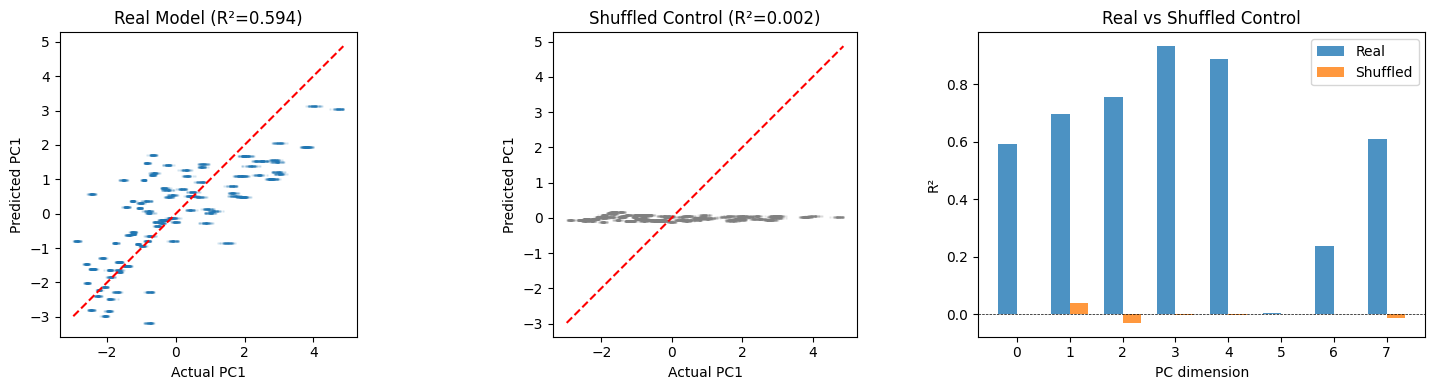

In [6]:
"""
Fit linear neural model: r = W_u f(u) + W_l f(l) + noise
"""

import torch
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA


def extract_neural_activity(trial_data, epoch='precue', time_idx=-1):
    """
    Extract neural activity at specific timepoint.
    
    Args:
        trial_data: Output from generate_trials()
        epoch: 'precue', 'durcue', or 'postcue'
        time_idx: Which timestep within epoch (-1 for last)
    
    Returns:
        activity: (batch_size, num_samples, num_dims)
    """
    prep_dicts = trial_data['novel_samples_prep_dicts']
    samples_dict = trial_data['novel_samples_dict']
    
    if epoch == 'precue':
        # Index 1 in prep_dicts is the precue period
        activity = prep_dicts[1]['preparatory_trajectory'][:, :, time_idx, :]
    elif epoch == 'durcue':
        # Index 2 is during cue
        activity = prep_dicts[2]['preparatory_trajectory'][:, :, time_idx, :]
    elif epoch == 'postcue':
        # Use embedded sample trajectory
        activity = samples_dict['embedded_sample_trajectory'][:, :, time_idx, :]
    else:
        raise ValueError(f"Unknown epoch: {epoch}")
    
    return activity


def preprocess_neural_data(activity, variance_threshold=0.95):
    """
    Z-score and PCA on neural data.
    
    Args:
        activity: (batch_size, num_samples, num_dims)
        variance_threshold: How much variance to retain
    
    Returns:
        preprocessed: (batch_size * num_samples, num_pca_dims)
        pca: Fitted PCA object
    """
    batch_size, num_samples, num_dims = activity.shape
    
    # Flatten trials and samples
    activity_flat = activity.reshape(-1, num_dims).cpu().numpy()
    
    # Z-score each dimension
    activity_z = (activity_flat - activity_flat.mean(0)) / (activity_flat.std(0) + 1e-8)
    
    # PCA
    pca = PCA(n_components=variance_threshold)
    activity_pca = pca.fit_transform(activity_z)
    
    return torch.from_numpy(activity_pca).float(), pca


def fit_delay1_model(trial_data, epoch='precue', time_idx=-1, alpha=1.0):
    """
    Fit model for delay 1: r = W_u f(u) + W_l f(l) + noise
    
    Args:
        trial_data: Output from generate_trials()
        epoch: Which epoch to analyze
        time_idx: Timepoint within epoch
        alpha: Ridge regression regularization
    
    Returns:
        dict with fitted parameters and preprocessing info
    """
    # Extract neural activity
    activity = extract_neural_activity(trial_data, epoch, time_idx)
    activity_pca, pca = preprocess_neural_data(activity)
    
    batch_size, num_samples = activity.shape[:2]
    num_dims = activity_pca.shape[1]
    
    # Get colors
    probe_features = trial_data['probe_features']  # (batch_size, 2)
    upper_colors = probe_features[:, 0]
    lower_colors = probe_features[:, 1]
    
    # Transform to spline basis
    upper_basis = spline_transform(upper_colors)  # (batch_size, K)
    lower_basis = spline_transform(lower_colors)  # (batch_size, K)
    
    # Repeat for samples
    upper_basis = upper_basis.unsqueeze(1).repeat(1, num_samples, 1).reshape(-1, num_knots)
    lower_basis = lower_basis.unsqueeze(1).repeat(1, num_samples, 1).reshape(-1, num_knots)
    
    # Concatenate into design matrix: [f(u), f(l)]
    X = torch.cat([upper_basis, lower_basis], dim=1).numpy()  # (N, 10)
    y = activity_pca.numpy()  # (N, num_dims)
    
    # Fit ridge regression
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(X, y)
    
    # Extract weight matrices
    W = ridge.coef_  # (num_dims, 10)
    Wu = W[:, :num_knots].T  # (num_knots, num_dims)
    Wl = W[:, num_knots:].T  # (num_knots, num_dims)
    
    return {
        'Wu': torch.from_numpy(Wu).float(),
        'Wl': torch.from_numpy(Wl).float(),
        'intercept': torch.from_numpy(ridge.intercept_).float(),
        'ridge': ridge,
        'pca': pca,
        'num_dims': num_dims,
        'activity_pca': activity_pca,
        'variance_explained': pca.explained_variance_ratio_.sum(),
    }


def predict_neural_state(upper_color, lower_color, model):
    """
    Predict neural state from colors using fitted model.
    
    Args:
        upper_color: Scalar or tensor of upper colors
        lower_color: Scalar or tensor of lower colors
        model: Output from fit_delay1_model()
    
    Returns:
        predicted_state: (num_dims,) or (batch, num_dims)
    """
    # Transform to spline basis
    upper_basis = spline_transform(upper_color)  # (..., 5)
    lower_basis = spline_transform(lower_color)  # (..., 5)
    
    # Apply weights
    Wu = model['Wu'].to(upper_basis.device)  # (5, num_dims)
    Wl = model['Wl'].to(lower_basis.device)  # (5, num_dims)
    intercept = model['intercept'].to(upper_basis.device)  # (num_dims,)
    
    # r = Wu^T f(u) + Wl^T f(l) + b
    pred = torch.matmul(upper_basis, Wu) + torch.matmul(lower_basis, Wl) + intercept
    
    return pred


def fit_shuffled_control(trial_data, epoch='precue', time_idx=-1, alpha=1.0):
    """
    Fit model to shuffled data as a control.
    Shuffles neural activity to break color-activity correspondence.
    """
    # Extract and preprocess as normal
    activity = extract_neural_activity(trial_data, epoch, time_idx)
    activity_pca, pca = preprocess_neural_data(activity)
    
    batch_size, num_samples = activity.shape[:2]
    
    # Get colors
    probe_features = trial_data['probe_features']
    upper_colors = probe_features[:, 0]
    lower_colors = probe_features[:, 1]
    
    # Transform to spline basis
    upper_basis = spline_transform(upper_colors).unsqueeze(1).repeat(1, num_samples, 1).reshape(-1, num_knots)
    lower_basis = spline_transform(lower_colors).unsqueeze(1).repeat(1, num_samples, 1).reshape(-1, num_knots)
    
    # SHUFFLE the neural activity (break correspondence)
    shuffled_idx = torch.randperm(activity_pca.shape[0])
    activity_shuffled = activity_pca[shuffled_idx]
    
    # Fit to shuffled data
    X = torch.cat([upper_basis, lower_basis], dim=1).numpy()
    y = activity_shuffled.numpy()
    
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(X, y)
    
    W = ridge.coef_
    Wu = W[:, :num_knots].T
    Wl = W[:, num_knots:].T
    
    return {
        'Wu': torch.from_numpy(Wu).float(),
        'Wl': torch.from_numpy(Wl).float(),
        'intercept': torch.from_numpy(ridge.intercept_).float(),
        'ridge': ridge,
        'pca': pca,
        'num_dims': activity_pca.shape[1],
        'activity_pca': activity_pca,  # Store original (unshuffled) for comparison
        'variance_explained': pca.explained_variance_ratio_.sum(),
    }


# Fit real model
fitted_model = fit_delay1_model(full_data, epoch='precue', time_idx=-1, alpha=1.0)

# Fit shuffled control
shuffled_model = fit_shuffled_control(full_data, epoch='precue', time_idx=-1, alpha=1.0)

batch_size = full_data['probe_features'].shape[0]
num_samples = full_data['swap_mask'].shape[1]

# Get predictions from both models
upper_colors = full_data['probe_features'][:, 0]
lower_colors = full_data['probe_features'][:, 1]

upper_colors_repeated = upper_colors.unsqueeze(1).repeat(1, num_samples).reshape(-1)
lower_colors_repeated = lower_colors.unsqueeze(1).repeat(1, num_samples).reshape(-1)

predictions_real = predict_neural_state(upper_colors_repeated, lower_colors_repeated, fitted_model)
predictions_shuffled = predict_neural_state(upper_colors_repeated, lower_colors_repeated, shuffled_model)

# Compare to actual
actual = fitted_model['activity_pca']

# Calculate R² for both
r2_real = 1 - ((actual - predictions_real).pow(2).sum(0) / 
               (actual - actual.mean(0)).pow(2).sum(0))
r2_shuffled = 1 - ((actual - predictions_shuffled).pow(2).sum(0) / 
                   (actual - actual.mean(0)).pow(2).sum(0))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Real model fit
ax = axes[0]
ax.scatter(actual[:, 0].numpy(), predictions_real[:, 0].numpy(), alpha=0.1, s=1)
ax.plot([actual[:, 0].min(), actual[:, 0].max()], 
        [actual[:, 0].min(), actual[:, 0].max()], 'r--')
ax.set_xlabel('Actual PC1')
ax.set_ylabel('Predicted PC1')
ax.set_title(f'Real Model (R²={r2_real[0]:.3f})')
ax.set_aspect('equal')

# Plot 2: Shuffled control fit
ax = axes[1]
ax.scatter(actual[:, 0].numpy(), predictions_shuffled[:, 0].numpy(), alpha=0.1, s=1, color='gray')
ax.plot([actual[:, 0].min(), actual[:, 0].max()], 
        [actual[:, 0].min(), actual[:, 0].max()], 'r--')
ax.set_xlabel('Actual PC1')
ax.set_ylabel('Predicted PC1')
ax.set_title(f'Shuffled Control (R²={r2_shuffled[0]:.3f})')
ax.set_aspect('equal')

# Plot 3: R² comparison across PCs
ax = axes[2]
x = np.arange(len(r2_real))
width = 0.35
ax.bar(x - width/2, r2_real.numpy(), width, label='Real', alpha=0.8)
ax.bar(x + width/2, r2_shuffled.numpy(), width, label='Shuffled', alpha=0.8)
ax.set_xlabel('PC dimension')
ax.set_ylabel('R²')
ax.set_title(f'Real vs Shuffled Control')
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax.legend()

plt.tight_layout()
plt.show()

In [4]:
"""
Project neural activity onto nominal→erroneous line over time
Three separate plots for three error mechanisms
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


def fit_delay2_model(trial_data, epoch='postcue', time_idx=-1, alpha=1.0):
    """
    Fit model for delay 2 with position-specific target/distractor weights.
    
    Returns 4 weight matrices:
    - Wt_upper: weights for upper color when it's the target
    - Wd_upper: weights for upper color when it's the distractor
    - Wt_lower: weights for lower color when it's the target
    - Wd_lower: weights for lower color when it's the distractor
    """
    activity = extract_neural_activity(trial_data, epoch, time_idx)
    activity_pca, pca = preprocess_neural_data(activity)
    
    batch_size, num_samples = activity.shape[:2]
    
    probe_features = trial_data['probe_features']
    cued_idx = trial_data['selected_feature_idx']
    
    upper_colors = probe_features[:, 0]
    lower_colors = probe_features[:, 1]
    
    # Transform to spline basis
    upper_basis = spline_transform(upper_colors).unsqueeze(1).repeat(1, num_samples, 1).reshape(-1, 5)
    lower_basis = spline_transform(lower_colors).unsqueeze(1).repeat(1, num_samples, 1).reshape(-1, 5)
    cued_idx_repeated = cued_idx.unsqueeze(1).repeat(1, num_samples).reshape(-1)
    
    # Build design matrix with 4 role-specific components
    # When upper is cued (cued_idx=0): upper is target, lower is distractor
    # When lower is cued (cued_idx=1): lower is target, upper is distractor
    
    upper_is_target = (cued_idx_repeated == 0).float()[:, None]  # (N, 1)
    upper_is_distractor = (cued_idx_repeated == 1).float()[:, None]
    lower_is_target = (cued_idx_repeated == 1).float()[:, None]
    lower_is_distractor = (cued_idx_repeated == 0).float()[:, None]
    
    # Create 4 components: [upper_target, upper_distractor, lower_target, lower_distractor]
    X_upper_target = upper_basis * upper_is_target
    X_upper_distractor = upper_basis * upper_is_distractor
    X_lower_target = lower_basis * lower_is_target
    X_lower_distractor = lower_basis * lower_is_distractor
    
    X = torch.cat([X_upper_target, X_upper_distractor, X_lower_target, X_lower_distractor], dim=1).numpy()  # (N, 20)
    y = activity_pca.numpy()
    
    # Fit ridge regression
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(X, y)
    
    # Extract 4 weight matrices
    W = ridge.coef_  # (num_dims, 20)
    Wt_upper = W[:, 0:num_knots].T    # (5, num_dims)
    Wd_upper = W[:, num_knots:2 * num_knots].T   # (5, num_dims)
    Wt_lower = W[:, 2 * num_knots:3 * num_knots].T  # (5, num_dims)
    Wd_lower = W[:, 3 * num_knots:].T  # (5, num_dims)
    
    return {
        'Wt_upper': torch.from_numpy(Wt_upper).float(),
        'Wd_upper': torch.from_numpy(Wd_upper).float(),
        'Wt_lower': torch.from_numpy(Wt_lower).float(),
        'Wd_lower': torch.from_numpy(Wd_lower).float(),
        'intercept': torch.from_numpy(ridge.intercept_).float(),
        'pca': pca,
        'num_dims': activity_pca.shape[1],
    }


def predict_delay2_state(upper_color, lower_color, cue_upper, model, error_type=None):
    """
    Predict delay 2 state with position-specific weights.
    
    Args:
        upper_color, lower_color: Color values
        cue_upper: Boolean tensor, True if upper is cued
        model: Fitted delay2 model with 4 weight matrices
        error_type: None, 'misselection', or 'misinterpretation'
    
    Returns:
        Predicted neural state
    """
    upper_basis = spline_transform(upper_color)
    lower_basis = spline_transform(lower_color)
    
    Wt_upper = model['Wt_upper'].to(upper_basis.device)
    Wd_upper = model['Wd_upper'].to(upper_basis.device)
    Wt_lower = model['Wt_lower'].to(upper_basis.device)
    Wd_lower = model['Wd_lower'].to(upper_basis.device)
    intercept = model['intercept'].to(upper_basis.device)
    
    if error_type is None:
        # Nominal: correct cue interpretation, correct color selection
        # When upper cued: Wt_upper @ f(upper) + Wd_lower @ f(lower)
        # When lower cued: Wt_lower @ f(lower) + Wd_upper @ f(upper)
        target_contrib = torch.where(
            cue_upper[..., None, None],
            torch.matmul(upper_basis.unsqueeze(-2), Wt_upper.unsqueeze(0)),
            torch.matmul(lower_basis.unsqueeze(-2), Wt_lower.unsqueeze(0))
        ).squeeze(-2)
        
        distractor_contrib = torch.where(
            cue_upper[..., None, None],
            torch.matmul(lower_basis.unsqueeze(-2), Wd_lower.unsqueeze(0)),
            torch.matmul(upper_basis.unsqueeze(-2), Wd_upper.unsqueeze(0))
        ).squeeze(-2)
        
    elif error_type == 'misselection':
        # Misselection: correct cue interpretation, SWAPPED colors
        # When upper cued: Wt_upper @ f(lower) + Wd_lower @ f(upper) [colors swapped!]
        # When lower cued: Wt_lower @ f(upper) + Wd_upper @ f(lower) [colors swapped!]
        target_contrib = torch.where(
            cue_upper[..., None, None],
            torch.matmul(lower_basis.unsqueeze(-2), Wt_upper.unsqueeze(0)),  # Wrong color!
            torch.matmul(upper_basis.unsqueeze(-2), Wt_lower.unsqueeze(0))   # Wrong color!
        ).squeeze(-2)
        
        distractor_contrib = torch.where(
            cue_upper[..., None, None],
            torch.matmul(upper_basis.unsqueeze(-2), Wd_lower.unsqueeze(0)),  # Wrong color!
            torch.matmul(lower_basis.unsqueeze(-2), Wd_upper.unsqueeze(0))   # Wrong color!
        ).squeeze(-2)
        
    elif error_type == 'misinterpretation':
        # Misinterpretation: WRONG cue interpretation, but consistent color-position mapping
        # When upper cued (but think lower): Wt_lower @ f(lower) + Wd_upper @ f(upper) [wrong weights!]
        # When lower cued (but think upper): Wt_upper @ f(upper) + Wd_lower @ f(lower) [wrong weights!]
        target_contrib = torch.where(
            cue_upper[..., None, None],
            torch.matmul(lower_basis.unsqueeze(-2), Wt_lower.unsqueeze(0)),  # Wrong weights!
            torch.matmul(upper_basis.unsqueeze(-2), Wt_upper.unsqueeze(0))   # Wrong weights!
        ).squeeze(-2)
        
        distractor_contrib = torch.where(
            cue_upper[..., None, None],
            torch.matmul(upper_basis.unsqueeze(-2), Wd_upper.unsqueeze(0)),  # Wrong weights!
            torch.matmul(lower_basis.unsqueeze(-2), Wd_lower.unsqueeze(0))   # Wrong weights!
        ).squeeze(-2)
    
    pred = target_contrib + distractor_contrib + intercept
    return pred



def project_onto_line(activity, nominal, erroneous):
    """Project onto line from nominal to erroneous."""
    direction = erroneous - nominal
    direction_norm = direction / (torch.norm(direction, dim=-1, keepdim=True) + 1e-8)
    projection = torch.sum((activity - nominal) * direction_norm, dim=-1)
    distance = torch.norm(erroneous - nominal, dim=-1)
    return projection / (distance + 1e-8)


def compute_projections_over_time(trial_data, train_subset, heldout_mask, heldout_is_correct, epochs, error_type):
    """
    Compute projections for a specific error type over specified epochs.
    Uses train subset for fitting, evaluates on held-out trials only.
    
    Args:
        trial_data: Full data including all trials
        train_subset: Subset of training correct trials for fitting
        heldout_mask: Boolean mask for held-out trials (test correct + swap)
        heldout_is_correct: Boolean array indicating which held-out trials are correct
        epochs: List of (epoch_name, timepoints, time_offset) tuples
        error_type: 'misbinding', 'misselection', or 'misinterpretation'
    """
    time_axis = []
    projections_all = []
    
    for epoch_name, num_steps, time_offset in epochs:
        for t in range(num_steps):
            if error_type == 'misbinding':
                model = fit_delay1_model(train_subset, epoch=epoch_name, time_idx=t, alpha=1.0)
                
                upper = trial_data['probe_features'][:, 0]
                lower = trial_data['probe_features'][:, 1]
                
                nominal = predict_neural_state(upper, lower, model).squeeze()
                misbound = predict_neural_state(lower, upper, model).squeeze()
                
                actual = extract_neural_activity(trial_data, epoch_name, t).squeeze()
                actual_pca = torch.from_numpy(model['pca'].transform(
                    ((actual.cpu().numpy() - actual.cpu().numpy().mean(0)) / 
                     (actual.cpu().numpy().std(0) + 1e-8))
                )).float()
                
                proj = project_onto_line(actual_pca, nominal, misbound)
                
            else:
                model = fit_delay2_model(train_subset, epoch=epoch_name, time_idx=t, alpha=1.0)
                
                upper = trial_data['probe_features'][:, 0]
                lower = trial_data['probe_features'][:, 1]
                cue_upper = (trial_data['selected_feature_idx'] == 0)
                
                nominal = predict_delay2_state(upper, lower, cue_upper, model, error_type=None).squeeze()
                erroneous = predict_delay2_state(upper, lower, cue_upper, model, error_type=error_type).squeeze()
                
                actual = extract_neural_activity(trial_data, epoch_name, t).squeeze()
                actual_pca = torch.from_numpy(model['pca'].transform(
                    ((actual.cpu().numpy() - actual.cpu().numpy().mean(0)) / 
                     (actual.cpu().numpy().std(0) + 1e-8))
                )).float()
                
                proj = project_onto_line(actual_pca, nominal, erroneous)
            
            # Only keep held-out trials
            proj_heldout = proj[heldout_mask].numpy()
            projections_all.append(proj_heldout)
            time_axis.append(t * 0.05 + time_offset)
    
    projections_all = np.array(projections_all)  # (time, heldout_trials)
    
    # Compute means and SEMs on held-out data only
    mean_correct = projections_all[:, heldout_is_correct].mean(axis=1)
    sem_correct = stats.sem(projections_all[:, heldout_is_correct], axis=1)
    
    mean_swap = projections_all[:, ~heldout_is_correct].mean(axis=1)
    sem_swap = stats.sem(projections_all[:, ~heldout_is_correct], axis=1)
    
    return time_axis, mean_correct, sem_correct, mean_swap, sem_swap


# Generate data: many trials, 1 sample each
many_trials_data = generate_trials(num_trials=2048 * 2, num_samples=1, use_fixed_probe_pair=None)

correct_mask = ~many_trials_data['swap_mask'].squeeze()
correct_indices = torch.where(correct_mask)[0]

# Train-test split on correct trials (80/20)
num_correct = len(correct_indices)
num_train = int(0.8 * num_correct)
perm = torch.randperm(num_correct)
train_indices = correct_indices[perm[:num_train]]
test_indices = correct_indices[perm[num_train:]]

# Create training subset (for fitting models)
train_subset = {
    'novel_samples_prep_dicts': [
        {k: v[train_indices] for k, v in d.items()} 
        for d in many_trials_data['novel_samples_prep_dicts']
    ],
    'novel_samples_dict': {
        k: v[train_indices] for k, v in many_trials_data['novel_samples_dict'].items()
    },
    'probe_features': many_trials_data['probe_features'][train_indices],
    'selected_feature_idx': many_trials_data['selected_feature_idx'][train_indices],
}

# Create held-out mask (test correct + all swap)
heldout_mask = torch.zeros(len(many_trials_data['probe_features']), dtype=torch.bool)
heldout_mask[test_indices] = True  # Test correct trials
heldout_mask[~correct_mask] = True  # All swap trials

# Labels for held-out trials
heldout_is_correct = torch.zeros(heldout_mask.sum(), dtype=torch.bool)
test_positions = torch.where(heldout_mask)[0]
for i, idx in enumerate(test_positions):
    heldout_is_correct[i] = correct_mask[idx]

# Get epoch durations
num_precue = many_trials_data['novel_samples_prep_dicts'][1]['preparatory_trajectory'].shape[2]
num_durcue = many_trials_data['novel_samples_prep_dicts'][2]['preparatory_trajectory'].shape[2]
num_postcue = many_trials_data['novel_samples_dict']['embedded_sample_trajectory'].shape[2]

# Define time domains for each error type
# Misbinding: precue + cue (before and during cue)
misbinding_epochs = [
    ('precue', num_precue, -0.75),  # Before cue
    ('durcue', num_durcue, 0.0),    # During cue
    # ('postcue', num_postcue, 0.25),   # Post cue (diffusion)
]

# Misselection/Misinterpretation: full trajectory (precue + cue + postcue)
selection_epochs = [
    ('precue', num_precue, -0.75),    # Before cue
    ('durcue', num_durcue, 0.0),      # Cue onset
    ('postcue', num_postcue, 0.25),   # Post cue (diffusion)
]

# Compute projections (using train for fitting, held-out for evaluation)
time_mb, mean_c_mb, sem_c_mb, mean_s_mb, sem_s_mb = compute_projections_over_time(
    many_trials_data, train_subset, heldout_mask, heldout_is_correct, misbinding_epochs, 'misbinding'
)

time_ms, mean_c_ms, sem_c_ms, mean_s_ms, sem_s_ms = compute_projections_over_time(
    many_trials_data, train_subset, heldout_mask, heldout_is_correct, selection_epochs, 'misselection'
)

time_mi, mean_c_mi, sem_c_mi, mean_s_mi, sem_s_mi = compute_projections_over_time(
    many_trials_data, train_subset, heldout_mask, heldout_is_correct, selection_epochs, 'misinterpretation'
)

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING
Running model to generate samples...
Identifying swap errors...
Swap rate: 9.912%


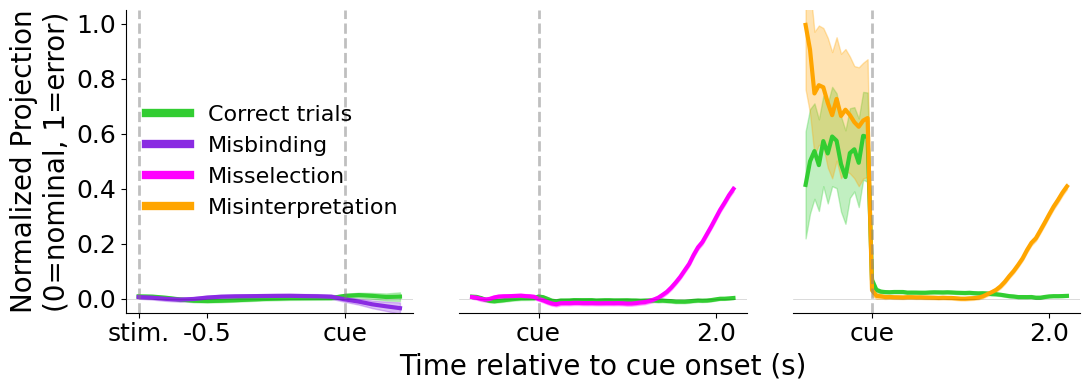

In [5]:
"""
Publication-quality plots for projection analysis
"""

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Plot
fig, axes = plt.subplots(1, 3, figsize=(11, 4))

# Plot 1: Misbinding
ax = axes[0]
ax.plot(time_mb, mean_c_mb, linewidth=3, color='limegreen')
ax.fill_between(time_mb, mean_c_mb - sem_c_mb, mean_c_mb + sem_c_mb, alpha=0.3, color='limegreen')
ax.plot(time_mb, mean_s_mb, linewidth=3, color='blueviolet')
ax.fill_between(time_mb, mean_s_mb - sem_s_mb, mean_s_mb + sem_s_mb, alpha=0.3, color='blueviolet')
ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=2)
ax.axvline(-0.75, color='gray', linestyle='--', alpha=0.5, linewidth=2)
ax.axhline(0, color='k', linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_ylabel('Normalized Projection\n(0=nominal, 1=error)', fontsize=20)
ax.set_ylim(-0.05, 1.05)
ax.tick_params(labelsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Explicitly set xticks to include key timepoints
current_xticks = list(ax.get_xticks())
if -0.75 not in current_xticks:
    current_xticks.append(-0.75)
if 0.0 not in current_xticks:
    current_xticks.append(0.0)
current_xticks = sorted(current_xticks)
ax.set_xticks(current_xticks[1:-1])
# Custom x-tick labels
xticklabels = []
for tick in current_xticks:
    if abs(tick - (-0.75)) < 0.01:
        xticklabels.append('stim.')
    elif abs(tick - 0.0) < 0.01:
        xticklabels.append('cue')
    else:
        xticklabels.append(f'{tick:.1f}')
ax.set_xticklabels(xticklabels[1:-1])

# Plot 2: Misselection
ax = axes[1]
ax.plot(time_ms, mean_c_ms, linewidth=3, color='limegreen')
ax.fill_between(time_ms, mean_c_ms - sem_c_ms, mean_c_ms + sem_c_ms, alpha=0.3, color='limegreen')
ax.plot(time_ms, mean_s_ms, linewidth=3, color='magenta')
ax.fill_between(time_ms, mean_s_ms - sem_s_ms, mean_s_ms + sem_s_ms, alpha=0.3, color='magenta')
ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=2)
ax.axhline(0, color='k', linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_ylim(-0.05, 1.05)
ax.set_yticks([])
ax.tick_params(labelsize=18)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# Explicitly set xticks to include key timepoints
current_xticks = list(ax.get_xticks())
if 0.0 not in current_xticks:
    current_xticks.append(0.0)
current_xticks = sorted(current_xticks)
ax.set_xticks(current_xticks[1:-1])
# Custom x-tick labels
xticklabels = []
for tick in current_xticks:
    if abs(tick - 0.0) < 0.01:
        xticklabels.append('cue')
    else:
        xticklabels.append(f'{tick:.1f}')
ax.set_xticklabels(xticklabels[1:-1])

# Plot 3: Misinterpretation
ax = axes[2]
ax.plot(time_mi, mean_c_mi, linewidth=3, color='limegreen')
ax.fill_between(time_mi, mean_c_mi - sem_c_mi, mean_c_mi + sem_c_mi, alpha=0.3, color='limegreen')
ax.plot(time_mi, mean_s_mi, linewidth=3, color='orange')
ax.fill_between(time_mi, mean_s_mi - sem_s_mi, mean_s_mi + sem_s_mi, alpha=0.3, color='orange')
ax.axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=2)
ax.axhline(0, color='k', linestyle='-', alpha=0.2, linewidth=0.5)
ax.set_ylim(-0.05, 1.05)
ax.set_yticks([])
ax.tick_params(labelsize=18)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# Explicitly set xticks to include key timepoints
current_xticks = list(ax.get_xticks())
if 0.0 not in current_xticks:
    current_xticks.append(0.0)
current_xticks = sorted(current_xticks)
ax.set_xticks(current_xticks[1:-1])
# Custom x-tick labels
xticklabels = []
for tick in current_xticks:
    if abs(tick - 0.0) < 0.01:
        xticklabels.append('cue')
    else:
        xticklabels.append(f'{tick:.1f}')
ax.set_xticklabels(xticklabels[1:-1])

# Manual legend on first subplot (centered)
legend_elements = [
    Line2D([0], [0], color='limegreen', linewidth=6, label='Correct trials'),
    Line2D([0], [0], color='blueviolet', linewidth=6, label='Misbinding'),
    Line2D([0], [0], color='magenta', linewidth=6, label='Misselection'),
    Line2D([0], [0], color='orange', linewidth=6, label='Misinterpretation'),
]
axes[0].legend(handles=legend_elements, loc='center left', fontsize=16, frameon=False)

axes[1].set_xlabel('Time relative to cue onset (s)', fontsize = 20)

plt.tight_layout()
fig.savefig('ddpm/analysis/cosyne2026/index_neural_mixture.pdf', transparent = True)
plt.show()
